In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Task 1

Do a short term forecast for the day 14 December 2020 in the frequency of 15
minutes.

# Importing Libraries:

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns

# Exploring the dataset:

Let's first read the dataset. 

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Electricity Load Forecasting/assignment-data.csv')

In [ ]:
data.head()

,Unnamed: 0,datetime,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,date
0,0,2018-01-01 00:00:00,803.22270,10.45800,10.45800,0.955500,8.946000,0.0,0.0,2018-01-01
1,1,2018-01-01 00:15:00,774.89523,10.32675,10.32675,0.961625,8.911875,0.0,0.0,2018-01-01
2,2,2018-01-01 00:30:00,731.46927,10.19550,10.19550,0.967750,8.877750,0.0,0.0,2018-01-01
3,3,2018-01-01 00:45:00,713.93870,10.06425,10.06425,0.973875,8.843625,0.0,0.0,2018-01-01
4,4,2018-01-01 01:00:00,699.23007,9.93300,9.93300,0.980000,8.809500,0.0,0.0,2018-01-01


In [ ]:
data.tail()

,Unnamed: 0,datetime,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,date
103387,103387,2020-12-12 22:45:00,858.50,17.79750,17.79750,0.756000,12.4005,1.950375,0.16275,2020-12-12
103388,103388,2020-12-12 23:00:00,832.24,17.66100,17.66100,0.756000,12.2640,2.047500,0.14700,2020-12-12
103389,103389,2020-12-12 23:15:00,804.97,17.46675,17.46675,0.758625,12.1275,2.144625,0.11550,2020-12-12
103390,103390,2020-12-12 23:30:00,763.56,17.27250,17.27250,0.761250,11.9910,2.241750,0.08400,2020-12-12
103391,103391,2020-12-12 23:45:00,734.27,17.07825,17.07825,0.763875,11.8545,2.338875,0.05250,2020-12-12


In [ ]:
data.shape

(103392, 10)

Since the Unanmed as well as Date column doesn't have any useful information therefore we are going to frop these two columns. 

In [ ]:
data.drop(['Unnamed: 0', 'date'], axis = 1, inplace  = True)

In [ ]:
data.head()

,datetime,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover
0,2018-01-01 00:00:00,803.22270,10.45800,10.45800,0.955500,8.946000,0.0,0.0
1,2018-01-01 00:15:00,774.89523,10.32675,10.32675,0.961625,8.911875,0.0,0.0
2,2018-01-01 00:30:00,731.46927,10.19550,10.19550,0.967750,8.877750,0.0,0.0
3,2018-01-01 00:45:00,713.93870,10.06425,10.06425,0.973875,8.843625,0.0,0.0
4,2018-01-01 01:00:00,699.23007,9.93300,9.93300,0.980000,8.809500,0.0,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103392 entries, 0 to 103391
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   datetime              103392 non-null  object 
 1   load                  101952 non-null  float64
 2   apparent_temperature  103392 non-null  float64
 3   temperature           103392 non-null  float64
 4   humidity              103392 non-null  float64
 5   dew_point             103392 non-null  float64
 6   wind_speed            103392 non-null  float64
 7   cloud_cover           103392 non-null  float64
dtypes: float64(7), object(1)
memory usage: 6.3+ MB


Let's try to fill the missing values in the electricity load column using the method of interpolation because we can't afford to have missing values in this column as we will be using this column as our ground truth label column to train our LSTM network. 

In [ ]:
data['load'] = data['load'].interpolate()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103392 entries, 0 to 103391
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   datetime              103392 non-null  object 
 1   load                  103392 non-null  float64
 2   apparent_temperature  103392 non-null  float64
 3   temperature           103392 non-null  float64
 4   humidity              103392 non-null  float64
 5   dew_point             103392 non-null  float64
 6   wind_speed            103392 non-null  float64
 7   cloud_cover           103392 non-null  float64
dtypes: float64(7), object(1)
memory usage: 6.3+ MB


# Preparing data for training: 

Let's first convert the datetime column to datetime object so that time delta calculations can be easily done on this column. 

In [ ]:
train_date = pd.to_datetime(data['datetime'])

In [ ]:
train_date

0        2018-01-01 00:00:00
1        2018-01-01 00:15:00
2        2018-01-01 00:30:00
3        2018-01-01 00:45:00
4        2018-01-01 01:00:00
                 ...        
103387   2020-12-12 22:45:00
103388   2020-12-12 23:00:00
103389   2020-12-12 23:15:00
103390   2020-12-12 23:30:00
103391   2020-12-12 23:45:00
Name: datetime, Length: 103392, dtype: datetime64[ns]

Let's seperate all the feature columns as well as the ground truth label column from the dataset. 

In [ ]:
cols = list(data)[1:8]

In [ ]:
cols

['load',
 'apparent_temperature',
 'temperature',
 'humidity',
 'dew_point',
 'wind_speed',
 'cloud_cover']

In [ ]:
df_for_training = data[cols].astype(float)

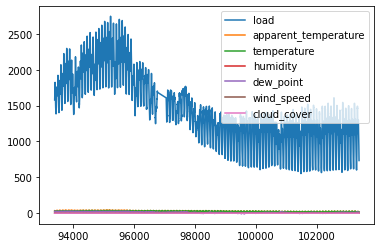

In [ ]:
df_for_plot = df_for_training.tail(10000)
df_for_plot.plot.line()

# Data Preprocessing: 

Now, what we are doing to do is that, we are going to normalize our data so that the gradient converges faster in the backpropagation while training the LSTM network, using this data. 

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

# Let's prepare the training data. 

In [ ]:
training_features = []
training_labels = []

In [ ]:
n_future = 1 #How many values are to be predicted in future 
n_past = 14 # How many past time steps values are to be taken into consideration to predict the future value. 

In [ ]:
for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    
    training_features.append(df_for_training_scaled[i - n_past:i,
                                           0:df_for_training_scaled.shape[1]])
    training_labels.append(df_for_training_scaled[i + n_future - 1:i +n_future, 0])

In [ ]:
training_features, training_labels = np.array(training_features), np.array(training_labels)

In [28]:
training_features.shape

(103378, 14, 7)

In [29]:
training_labels.shape

(103378, 1)

# LSTM Model 

In [30]:
model = Sequential()
model.add(LSTM(
    128, 
    activation = 'relu',
    input_shape = (training_features.shape[1], training_features.shape[2]),
    return_sequences = True
))
model.add(LSTM(
    64, 
    activation = 'relu',
    return_sequences = False
))
model.add(Dropout(0.5))
model.add(Dense(training_labels.shape[1]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 128)           69632     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 119,105
Trainable params: 119,105
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

In [32]:
history = model.fit(
    training_features,
    training_labels,
    epochs = 10,
    batch_size = 128,
    validation_split = 0.3,
    verbose =1,
    shuffle = False 
)

Epoch 1/10
566/566 [==============================] - 53s 87ms/step - loss: 0.1223 - val_loss: 0.1016
Epoch 2/10
566/566 [==============================] - 47s 83ms/step - loss: 0.0560 - val_loss: 0.0414
Epoch 3/10
566/566 [==============================] - 48s 84ms/step - loss: 0.0486 - val_loss: 0.0275
Epoch 4/10
566/566 [==============================] - 50s 89ms/step - loss: 0.0470 - val_loss: 0.0205
Epoch 5/10
566/566 [==============================] - 47s 83ms/step - loss: 0.0455 - val_loss: 0.0226
Epoch 6/10
566/566 [==============================] - 47s 84ms/step - loss: 0.0451 - val_loss: 0.0129
Epoch 7/10
566/566 [==============================] - 47s 83ms/step - loss: 0.0442 - val_loss: 0.0230
Epoch 8/10
566/566 [==============================] - 47s 83ms/step - loss: 0.0441 - val_loss: 0.0185
Epoch 9/10
566/566 [==============================] - 49s 86ms/step - loss: 0.0442 - val_loss: 0.0108
Epoch 10/10
566/566 [==============================] - 50s 88ms/step - loss: 0.044

# Visualizing Training and Validation loss:

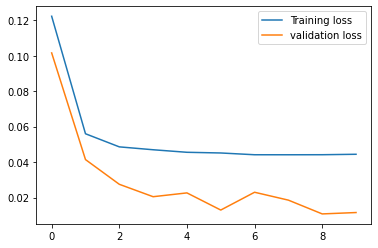

In [33]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

In [36]:
n_future = 194 # We will be trying to predict the future 194 values through our model. 

In [37]:
train_date

0        2018-01-01 00:00:00
1        2018-01-01 00:15:00
2        2018-01-01 00:30:00
3        2018-01-01 00:45:00
4        2018-01-01 01:00:00
                 ...        
103387   2020-12-12 22:45:00
103388   2020-12-12 23:00:00
103389   2020-12-12 23:15:00
103390   2020-12-12 23:30:00
103391   2020-12-12 23:45:00
Name: datetime, Length: 103392, dtype: datetime64[ns]

In [38]:
# This is going to be the forecasting datetime period for which want to predict the values in future using our trained model.
forecast_period_dates = pd.date_range(
    list(train_date)[-1],
    periods = n_future,
    freq = "15min"
).tolist()

In [39]:
forecast_period_dates[1:]

[Timestamp('2020-12-13 00:00:00', freq='15T'),
 Timestamp('2020-12-13 00:15:00', freq='15T'),
 Timestamp('2020-12-13 00:30:00', freq='15T'),
 Timestamp('2020-12-13 00:45:00', freq='15T'),
 Timestamp('2020-12-13 01:00:00', freq='15T'),
 Timestamp('2020-12-13 01:15:00', freq='15T'),
 Timestamp('2020-12-13 01:30:00', freq='15T'),
 Timestamp('2020-12-13 01:45:00', freq='15T'),
 Timestamp('2020-12-13 02:00:00', freq='15T'),
 Timestamp('2020-12-13 02:15:00', freq='15T'),
 Timestamp('2020-12-13 02:30:00', freq='15T'),
 Timestamp('2020-12-13 02:45:00', freq='15T'),
 Timestamp('2020-12-13 03:00:00', freq='15T'),
 Timestamp('2020-12-13 03:15:00', freq='15T'),
 Timestamp('2020-12-13 03:30:00', freq='15T'),
 Timestamp('2020-12-13 03:45:00', freq='15T'),
 Timestamp('2020-12-13 04:00:00', freq='15T'),
 Timestamp('2020-12-13 04:15:00', freq='15T'),
 Timestamp('2020-12-13 04:30:00', freq='15T'),
 Timestamp('2020-12-13 04:45:00', freq='15T'),
 Timestamp('2020-12-13 05:00:00', freq='15T'),
 Timestamp('2

In [40]:
len(forecast_period_dates)

194

In [42]:
# Let's predict the values using our trained model
forecast = model.predict(training_features[-n_future:])

In [43]:
forecast

array([[-1.3927425 ],
       [-1.5095967 ],
       [-1.5427417 ],
       [-1.6373254 ],
       [-1.6042048 ],
       [-1.6007773 ],
       [-1.6227301 ],
       [-1.6503478 ],
       [-1.6639636 ],
       [-1.6741663 ],
       [-1.6787448 ],
       [-1.6953496 ],
       [-1.70984   ],
       [-1.7014543 ],
       [-1.7101659 ],
       [-1.7096808 ],
       [-1.7047086 ],
       [-1.7044185 ],
       [-1.6958891 ],
       [-1.6760297 ],
       [-1.6494133 ],
       [-1.6027575 ],
       [-1.5539523 ],
       [-1.4786397 ],
       [-1.3981537 ],
       [-1.3107708 ],
       [-1.2215898 ],
       [-1.0800456 ],
       [-0.95113343],
       [-0.8625093 ],
       [-0.7915252 ],
       [-0.6818891 ],
       [-0.52119344],
       [-0.3989141 ],
       [-0.32276   ],
       [-0.2714079 ],
       [-0.23126738],
       [-0.22572272],
       [-0.25238895],
       [-0.21824436],
       [-0.2094083 ],
       [-0.18042217],
       [-0.11504333],
       [-0.10622077],
       [-0.08421992],
       [-0

In [44]:
len(forecast)

194

In [45]:
forecast_copy = np.repeat(
    forecast,
    df_for_training.shape[1],
    axis = 1
)

In [46]:
# Here, we will be applying inverse transformation to our forecasted values to get the unnormalized predictions. 
y_pred_future = scaler.inverse_transform(forecast_copy)[:,0]

In [47]:
y_pred_future.shape

(194,)

In [48]:
forecast_dates = []
for time_i in forecast_period_dates:
  forecast_dates.append(time_i.timestamp())

In [49]:
forecast_dates = pd.to_datetime(forecast_dates, unit = 's')

In [50]:
forecast_dates

DatetimeIndex(['2020-12-12 23:45:00', '2020-12-13 00:00:00',
               '2020-12-13 00:15:00', '2020-12-13 00:30:00',
               '2020-12-13 00:45:00', '2020-12-13 01:00:00',
               '2020-12-13 01:15:00', '2020-12-13 01:30:00',
               '2020-12-13 01:45:00', '2020-12-13 02:00:00',
               ...
               '2020-12-14 21:45:00', '2020-12-14 22:00:00',
               '2020-12-14 22:15:00', '2020-12-14 22:30:00',
               '2020-12-14 22:45:00', '2020-12-14 23:00:00',
               '2020-12-14 23:15:00', '2020-12-14 23:30:00',
               '2020-12-14 23:45:00', '2020-12-15 00:00:00'],
              dtype='datetime64[ns]', length=194, freq=None)

In [51]:
forecast_dates = np.array(forecast_dates)
forecast_dates.shape

(194,)

In [52]:
y_pred_future.shape

(194,)

# Saving the predictions into CSV format.

In [53]:
df_forecast = pd.DataFrame()

In [54]:
df_forecast['datetime'] = forecast_dates

In [55]:
df_forecast['load'] = y_pred_future

In [56]:
df_forecast

,datetime,load
0,2020-12-12 23:45:00,821.363770
1,2020-12-13 00:00:00,759.211792
2,2020-12-13 00:15:00,741.582764
3,2020-12-13 00:30:00,691.275879
4,2020-12-13 00:45:00,708.891968
...,...,...
189,2020-12-14 23:00:00,888.421082
190,2020-12-14 23:15:00,848.172974
191,2020-12-14 23:30:00,822.566406
192,2020-12-14 23:45:00,801.440491
